### DEMDP06 
# Deterministic Optimal Economic Growth Model

Welfare maximizing social planner must decide how much society should consume and invest.  Model is of special interest because it has a known closed-form solution.

- States
    -     s       stock of wealth
- Actions
    -     k       capital investment
- Parameters
    -     beta    capital production elasticity
    -     delta   discount factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, DPmodel, DPoptions, qnwnorm, demo

### Model parameters

Assuming that the marginal productivity of capital is $\beta=0.5$ and the discount factor is $\delta=0.9$

In [2]:
β, δ = 0.5, 0.9

## Analytic results

The steady-state values for this model are

In [3]:
sstar = (β * δ) ** (β / (1 - β))   # steady-state wealth
kstar = β * δ * sstar                    # steady-state capital investment
vstar = np.log(sstar - kstar) / (1 - δ)     # steady-state value
pstar = 1 / (sstar * (1 - β * δ))        # steady-state shadow price
b = 1 / (1 - δ * β)

print('\n\nSteady-State')
for var, value in zip(['Wealth','Investment','Value','Shadow price'], [sstar,kstar,vstar,pstar]):
    print(f'\t{var:12s} = {value:8.4f}')



Steady-State
	Wealth       =   0.4500
	Investment   =   0.2025
	Value        = -13.9634
	Shadow price =   4.0404


The true value function is
\begin{equation}
V(s) = v^* + \frac{1}{1-\delta\beta}\left(\log(s) -\log(s^*)\right)
\end{equation}

In [4]:
def vtrue(wealth): # analytic value function
    return vstar + b * (np.log(wealth) - np.log(sstar))

The true policy function is
\begin{equation}
k(s) = \delta\beta s
\end{equation}

In [5]:
def ktrue(wealth): #analytic policy function
    return δ*β*wealth

## Numeric results

### State space
The state variable is s="Wealth", which we restrict to $0\in[0.2, 1.0]$. 

Here, we represent it with a Chebyshev basis, with $n=15$ nodes.

In [6]:
n, smin, smax = 15, 0.2, 1.0
basis = BasisChebyshev(n, smin, smax, labels=['Wealth'])

### Action space
The choice variable k="Investment" must be nonnegative.

In [7]:
def bounds(s, i=None, j=None):
    return np.zeros_like(s), s[:]

### Reward function
The reward function is the utility of consumption=$s-k$.

In [8]:
def reward(s, k, i=None, j=None):
    sk = s - k
    u = np.log(sk)
    ux= - sk ** -1
    uxx = - sk ** -2
    return u, ux, uxx

### State transition function
Next period, wealth will be equal to production from available initial capital $k$, that is $s' = k^\beta$

In [9]:
def transition(s, k, i=None, j=None, in_=None, e=None):
    g = k ** β
    gx = β * k **(β - 1)
    gxx = (β - 1) * β * k ** (β - 2)
    return g, gx, gxx

### Model structure
The value of wealth $s$ satisfies the Bellman equation
\begin{equation*}
V(s) = \max_k\left\{\log(s-k) + \delta V(k^\beta)  \right\}
\end{equation*}

To solve and simulate this model,use the CompEcon class `DPmodel`

In [26]:
growth_model = DPmodel(basis, reward, transition, bounds,
                       x=['Investment'],
                       discount=δ)

### Solving the model

Solving the growth model by collocation, using *Newton* algorithm and a maximum of 20 iterations

In [25]:
options = dict(print=True,
               algorithm='newton',
               maxit=20)

snodes = growth_model.Value.nodes
S = growth_model.solve(vtrue(snodes), ktrue(snodes), **options)

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       4.7e-07    0.0313
   1       1.6e-12    0.0313
Elapsed Time =    0.03 Seconds


`DPmodel.solve` returns a pandas `DataFrame` with the following data:

In [12]:
S.head()

,Wealth,value,resid,Investment
Wealth,,,,
0.200000,0.200000,-15.437865,2.766030e-07,0.090000
0.205369,0.205369,-15.389699,-2.099164e-07,0.092416
0.210738,0.210738,-15.342776,-2.488242e-07,0.094832
0.216107,0.216107,-15.297033,-1.102768e-07,0.097248
0.221477,0.221477,-15.252412,5.644805e-08,0.099664


We are also interested in the shadow price of wealth (the first derivative of the value function) and the approximation error.

To analyze the dynamics of the model, it also helps to compute the optimal change of wealth.

In [13]:
S['shadow price'] = growth_model.Value(S['Wealth'],1)
S['error'] = S['value'] - vtrue(S['Wealth'])
S['D.Wealth'] = transition(S['Wealth'], S['Investment'])[0] - S['Wealth']
S.head()

,Wealth,value,resid,Investment,shadow price,error,D.Wealth
Wealth,,,,,,,
0.200000,0.200000,-15.437865,2.766030e-07,0.090000,9.090758,4.241867e-07,0.100000
0.205369,0.205369,-15.389699,-2.099164e-07,0.092416,8.853206,-3.099040e-08,0.098631
0.210738,0.210738,-15.342776,-2.488242e-07,0.094832,8.627699,-4.010327e-08,0.097210
0.216107,0.216107,-15.297033,-1.102768e-07,0.097248,8.413362,1.253504e-07,0.095739
0.221477,0.221477,-15.252412,5.644805e-08,0.099664,8.209399,3.151234e-07,0.094220


### Solving the model by Linear-Quadratic Approximation

The `DPmodel.lqapprox` solves the linear-quadratic approximation, in this case arround the steady-state. It returns a LQmodel which works similar to the DPmodel object.

We also compute the shadow price and the approximation error to compare these results to the collocation results.

In [14]:
growth_lq = growth_model.lqapprox(sstar, kstar)
L = growth_lq.solution(basis.nodes)
L['shadow price'] = L['value_Wealth']
L['error'] = L['value'] - vtrue(L['Wealth'])
L['D.Wealth'] = L['Wealth_next']- L['Wealth']
L.head()

,Wealth,Investment,value,value_Wealth,Wealth_next,shadow price,error,D.Wealth
Wealth,,,,,,,,
0.202191,0.202191,-0.020528,-15.014820,4.444953,0.202192,4.444953,0.403234,2.977733e-07
0.219577,0.219577,-0.004880,-14.937786,4.416570,0.219578,4.416570,0.330284,2.769166e-07
0.253590,0.253590,0.025731,-14.788512,4.361045,0.253590,4.361045,0.217716,2.361148e-07
0.302742,0.302742,0.069968,-14.576129,4.280804,0.302742,4.280804,0.107984,1.771510e-07
0.364886,0.364886,0.125897,-14.313256,4.179353,0.364886,4.179353,0.031397,1.026024e-07


In [15]:
growth_lq.G

array([[1.]])

## Plotting the results

### Optimal Policy

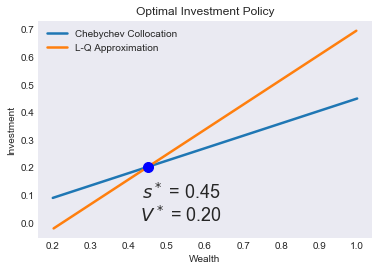

In [16]:
fig1 = demo.figure('Optimal Investment Policy', 'Wealth', 'Investment')
plt.plot(S.Investment, label='Chebychev Collocation')
plt.plot(L.Investment, label='L-Q Approximation')
demo.annotate(sstar, kstar,'$s^*$ = %.2f\n$V^*$ = %.2f' % (sstar, kstar),'bo', (10, -17),ms=10)
plt.legend(loc= 'upper left')

### Value Function

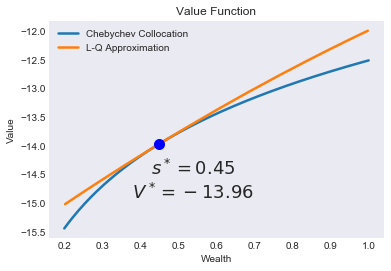

In [17]:
fig2 = demo.figure('Value Function', 'Wealth', 'Value')
plt.plot(S.value, label='Chebychev Collocation')
plt.plot(L.value, label='L-Q Approximation')

demo.annotate(sstar, vstar, f'$s^* = {sstar:.2f}$\n$V^* = {vstar:.2f}$', 'bo', (10, -17),ms=10)
plt.legend(loc= 'upper left')

### Shadow Price Function

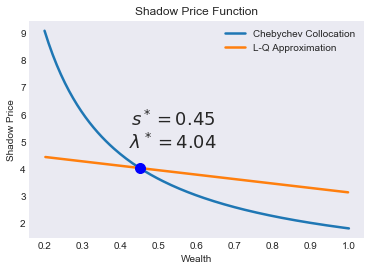

In [18]:
fig3 = demo.figure('Shadow Price Function', 'Wealth', 'Shadow Price')
plt.plot(S['shadow price'], label='Chebychev Collocation')
plt.plot(L['shadow price'], label='L-Q Approximation')
demo.annotate(sstar, pstar,f'$s^* = {sstar:.2f}$\n$\lambda^* = {pstar:.2f}$', 'bo', (10, 17),ms=10)
plt.legend(loc= 'upper right')

### Chebychev Collocation Residual and Approximation Error vs. Linear-Quadratic Approximation Error

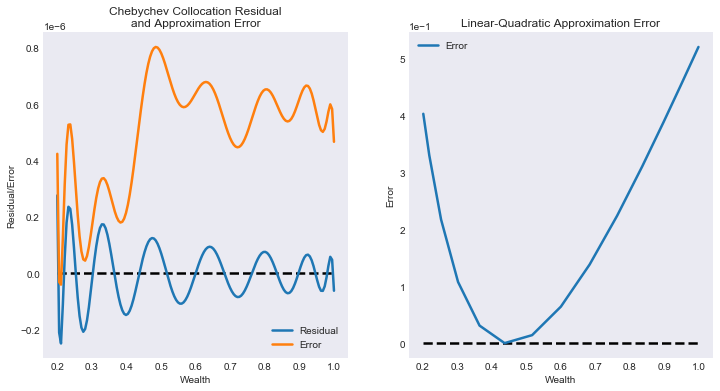

In [19]:
fig4 = plt.figure(figsize=[12, 6])
demo.subplot(1, 2, 1, 'Chebychev Collocation Residual\nand Approximation Error', 'Wealth', 'Residual/Error')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(S[['resid', 'error']])
plt.legend(['Residual','Error'], loc='lower right')
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

demo.subplot(1, 2, 2, 'Linear-Quadratic Approximation Error', 'Wealth', 'Error')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(L['error'], label='Error')
plt.legend(loc='upper left')
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

### Wealth dynamics

Notice how the steady-state is stable in the Chebyshev collocation solution, but unstable in the linear-quadratic approximation. In particular, simulated paths of wealth in the L-Q approximation will converge to zero, unless the initial states is within a small neighborhood of the steady-state.

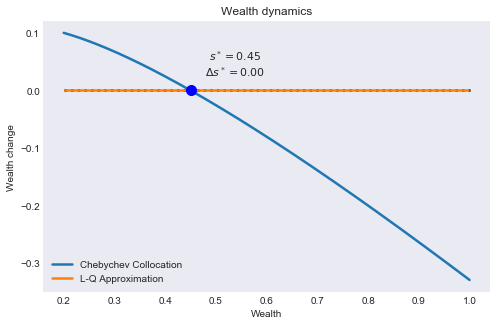

In [20]:
fig5 = demo.figure('Wealth dynamics', 'Wealth', 'Wealth change', figsize=[8,5])
plt.plot(S['D.Wealth'], label='Chebychev Collocation')
plt.plot(L['D.Wealth'], label='L-Q Approximation')
plt.hlines(0,smin,smax,linestyles=':')

demo.annotate(sstar, 0, f'$s^* = {sstar:.2f}$\n$\Delta s^* = {0:.2f}$', 'bo', (10, 10),ms=10,fs=11)
plt.legend(loc= 'lower left')

## Simulating the model

We simulate 20 periods of the model starting from $s=s_{\min}$

In [24]:
T = 20
data = growth_model.simulate(T, smin)

### Simulated State and Policy Paths

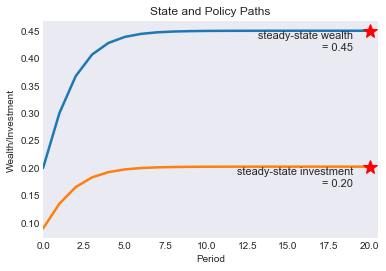

In [22]:
opts = dict(spec='r*', offset=(-5, -5), fs=11, ha='right')

fig6 = demo.figure('State and Policy Paths','Period', 'Wealth/Investment',[0, T + 0.5])
plt.plot(data[['Wealth', 'Investment']])
demo.annotate(T, sstar, 'steady-state wealth\n = %.2f' % sstar, **opts)
demo.annotate(T, kstar, 'steady-state investment\n = %.2f' % kstar, **opts)

In [23]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5,fig6])